# Задачи классификации

In [1]:
import logging
import os
import shutil 

import numpy as np

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  # гарантируем воспроизводимость

logging.getLogger().setLevel(logging.INFO)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info('Инициализировали логгер')

2023-03-16 06:05:33,980 : INFO : Инициализировали логгер


Загружаем данные - у нас будет новый датасет с задачей классификации

In [2]:
import os

import numpy as np
import pandas as pd

raw_data_file = 'client_segmentation.csv'

# задаём типизацию колонок чтобы память экономить
df_source = pd.read_csv(
    raw_data_file, sep=',',
    dtype={
        'call_diff': np.float32,
        'call_diff': np.float32,
        'traffic_diff': np.float32,
        'customes_class': np.uint16
    }
)

df_source.head(5)

2023-03-16 06:05:34,168 : INFO : Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-03-16 06:05:34,169 : INFO : NumExpr defaulting to 8 threads.


,call_diff,sms_diff,traffic_diff,customes_class
0,-0.666421,0.444911,-0.273538,0
1,-0.889273,-0.537896,-1.959469,2
2,-0.841503,0.846665,0.727606,0
3,1.389749,0.390911,1.789246,1
4,-1.228211,-1.375899,-1.434209,2


В файле `client_segmentation.csv` содержатся данные по оттоку: информация по клиентам оператора связи о том, как изменилось потребление услуг оператора за два месяца:
* call_diff доля звонков
* sms_diff доля смс
* доля интернет-трафика traffic_diff

Значение отрицательное - показатель снизился. Значение превосходит по модулю единицу - потребление кратно выросло. 

Все показатели вычисляются по формуле

$$
\frac{\text{new_value}-\text{old_value}}{\text{old_value}}
$$

Посмотрим на распределение какой-нибудь фичи, например `sms_diff`

<AxesSubplot: >

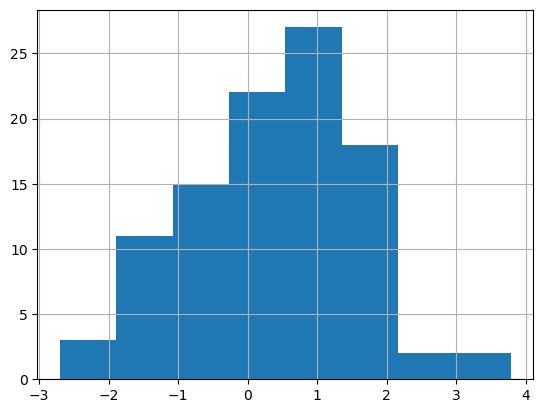

In [3]:
df_source.sms_diff.hist(bins=8)

В последней колонке `customes_class` содержится метка по оттоку:
* $0$ - активный пользователь
* $1$ - "спящий" пользователь (редко пользуется услугами)
* $2$ - пользователь, который ушел в отток

Это наша целевая переменная, хотим её предсказывать

In [4]:
logger.info('num train samples %d', df_source.shape[0])
df_source.customes_class.value_counts(normalize=True)

2023-03-16 06:05:34,587 : INFO : num train samples 100


0    0.34
2    0.33
1    0.33
Name: customes_class, dtype: float64

Видим, что у нас примерно одинакоково представлены все классы. Ситуация, когда один класс представлен слишком сильно и ли наоборот слишком слабо в выборке называется "дисбаланс классов". 

Есть два основных приёма решения проблемы дисбаланса
* undersampling доминирующего класса
* oversampling класса с меньшим числом элементов

Важный момент: дальше мы будем решать задачу классификации на 2 класса

Для этого искусственно разделим класс `2` между классами `0` и `1`

In [5]:
df_source[(df_source.customes_class==2) & (df_source.call_diff>1.1)] = 0
df_source[(df_source.customes_class==2) & (df_source.call_diff<=1.1)] = 1

X = df_source[['call_diff','sms_diff','traffic_diff']].values
y = df_source.customes_class.values

# Naive Bayes

Попробуем для решения задачи использовать классификатор "из коробки": воспользуемся  [наивным Байесовским классификатором](https://scikit-learn.org/stable/modules/naive_bayes.html). Кстати, реализация содержит функцию `.partial_fit()` с которой мы уже встречались! Вспомните где именно.

Этот классификатор основан на частотах встречаемости фичей. У нас фичи непрерывные, так что вместо частот будем использовать вероятности.

Классификатор очень быстро обучается, т.к. по сути нам нужно просто посчитать разные статистики по выборке - никакого градиентного спуска тут нет.

In [6]:
from collections import Counter

num_samples = df_source.shape[0]  # число объектов
prior_class_counts = Counter(y)  # группируем по классу и считаем колияество объектов каждого класса
prior_class_probs = dict() # тут будем хранить  априорные вероятности классов
print(prior_class_counts)
for class_label in prior_class_counts:
      prior_class_probs[class_label] = prior_class_counts[class_label] / num_samples
print(prior_class_probs)

Counter({1: 66, 0: 34})
{0: 0.34, 1: 0.66}


In [7]:
from collections import defaultdict

target_col = 'customes_class'
feature_names = ['call_diff','sms_diff','traffic_diff']

feature_proba_param = defaultdict(dict)
for col in feature_names:  # цикл по фичам
        for class_id in prior_class_probs:  # цикл по классам
            feature_values = df_source[df_source[target_col]==class_id][col]  # отфильтруем фичу по классу
            feature_proba_param[col][class_id] = {
                'mu': feature_values.mean(), 
                'sigma': feature_values.std()
            }
            
# посмотрим распределение статистике по конкретной фиче
feature_example = 'call_diff'
print(feature_example)
feature_proba_param[feature_example]

call_diff


{0: {'mu': -1.0015249, 'sigma': 0.7415683269500732},
 1: {'mu': 1.1297727, 'sigma': 0.44200706481933594}}

По сути мы нашли  параметры распределения - можем посчитать вероятности классов

Теперь можем построить алгоритм предсказания с помощью MAP
* для объекта $x$ считаем $P(c_1 | X), P(c_2 | X), P(c_3 | X)$
* выбираем максимальную вероятность - это и будет наше предсказание

время познакомится с библиотекой [scipy](https://docs.scipy.org/) - оттуда возьмём реализацию $P(X | c)$ для [распределения гаусса](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)

In [8]:
from scipy.stats import norm


def eval_bayes(row):
    log_classes_probas = defaultdict(float)  # т.к. нужно собирать сумму из разных фичей
    for feature in feature_names:
        feature_params = feature_proba_param[feature]  # извлекаем параметры распределения фичи (там три класса)
        for class_id in feature_params:  # считаем априорную вероятность получить такое значение фичи в каждом классе
            feature_class_params = feature_params[class_id]  # достаём параметры распределения (mu, sigma), которые посчитали на предыдущем шаге
            feature_class_proba = norm.pdf(
                  row[feature],
                  loc=feature_class_params['mu'], scale=feature_class_params['sigma']
              )
              # вероятность в интервале [0, 1] - там отрицательные значения логарифма
            log_classes_probas[class_id] += np.log(feature_class_proba)
    sorted_log_classes_probas = sorted(log_classes_probas.items(), key = lambda x: x[1], reverse=True)
    predicted_class, predicted_class_proba = sorted_log_classes_probas[0]
    return predicted_class, predicted_class_proba

def predict(input_df):
    res = []
    for _, row in input_df.iterrows():
        class_label, _ = eval_bayes(row)
        res.append(class_label)
    return res

def predict_proba(input_df):
    res = []
    for _, row in input_df.iterrows():
        _, class_proba = eval_bayes(row)
        res.append(class_proba)
    return res

# predict_proba(df_source[feature_names].head(1))
predicted_classes = predict(df_source[feature_names])
accuracy = (predicted_classes == y).sum() / len(y)
logger.info('Предсказания построены, accuracy = %.2f', accuracy)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
2023-03-16 06:05:34,923 : INFO : Предсказания построены, accuracy = 0.96


Проверим точность классификатора в реализации sklearn

In [9]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB() # создаём экземпляр класса
naive_bayes.fit(X, y) # обучение модели
predicted_classes = naive_bayes.predict(X) # предсказание (эксплуатация модели)

accuracy = (predicted_classes == y).sum() / len(y)

logger.info('Предсказания построены, accuracy = %.2f', accuracy)

2023-03-16 06:05:34,980 : INFO : Предсказания построены, accuracy = 0.97


Визуализируем confusion matrix

Кoличество объектов в тестовой выборке: 33


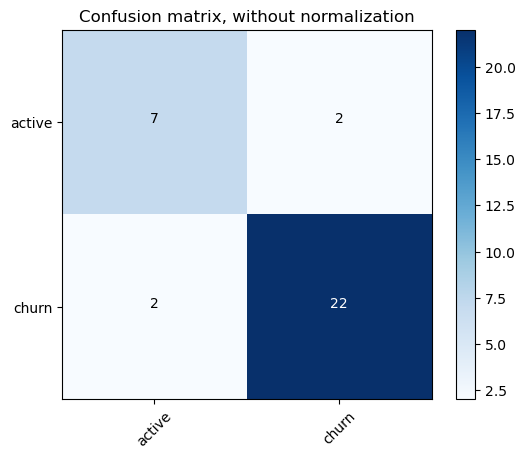

In [10]:
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools


X = df_source[['call_diff','sms_diff','traffic_diff']].values
y = df_source.customes_class.values

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
naive_bayes.fit(X_train, y_train)
y_pred = naive_bayes.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(
    conf_matrix,
    classes=['active', 'churn'],
    title='Confusion matrix, without normalization'
)
print(f'Кoличество объектов в тестовой выборке: {len(y_pred)}')

Самостоятельное задание: постройте бейзлайн в виде рандомного предсказания классов. Выбор класса должен делаться случайным образом, но вероятность класса $1$ возьмите такую же, как в исходном датасете. 

In [11]:
from random import choices

p = [0, 1]
weights = [0.34, 0.66]

def predict(input_df):
    res = []
    for _, row in input_df.iterrows():
        class_label = choices(p, weights)
        res.append(class_label)
    return res

predicted_classes = predict(df_source[feature_names])
accuracy = (predicted_classes == y).sum() / len(y)
logger.info('Предсказания построены, accuracy = %.2f', accuracy)

2023-03-16 06:05:35,106 : INFO : Предсказания построены, accuracy = 57.68


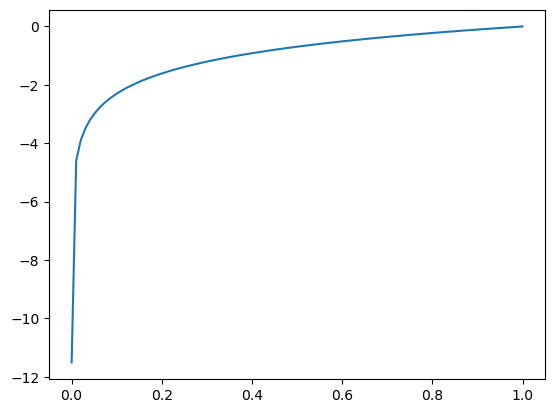

In [12]:
import numpy as np
from matplotlib import pyplot as plt
x_space = np.linspace(0.00001, 1, num=100)
plt.plot(x_space, np.log(x_space))

# Logistic regression


In [13]:
def sigmoid(z):
    return 1 / ( 1. + np.exp(-z))

x = np.array([1, 2, 3, 5])
sigmoid(x)

array([0.73105858, 0.88079708, 0.95257413, 0.99330715])

Далее собственно градиентный спуск

In [14]:
from scipy.spatial import distance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def gradient(X, y, w, alpha=0) -> np.array:
    """Вычисляем градиент в точке"""
    # количество обучающих примеров в выборке
    n = X.shape[0]
    # считаем прогноз
    y_hat = sigmoid(X.dot(w.T))
    # вычисляем ошибку прогноза
    error = (y - y_hat).reshape(1, -1)
    # дальше pointwise перемножение - умножаем каждую из координат на ошибку
    grad = (-1.) * error.dot(X) / n
    return grad, error

def eval_w_next(X, y, eta, w_current):
    """Делаем шаг градиентного спуска"""
    # вычисляем градиент
    grad, error = gradient(X, y, w_current)
    # делаем шаг градиентного спуска
    w_next = w_current - eta*grad
    # проверяем условие сходимости
    weight_evolution = np.linalg.norm(w_current - w_next)
    return (w_next, weight_evolution, grad)

Повторяем шаги до сходимости

In [15]:
def gradient_descent(X: np.array, y: np.array, eta=0.01, epsilon=0.001) -> np.array:
    m = X.shape[1] # количество фичей
    # инициализируем рандомом веса
    w = np.random.random(m).reshape(1, -1)
    w_next, weight_evolution, grad = eval_w_next(X, y, eta, w)
    step = 0
    # повторяем до сходимости вектора весов
    while weight_evolution > epsilon:
        w = w_next
        w_next, weight_evolution, grad = eval_w_next(X, y, eta, w)
        step += 1
        if step % 100 == 0:
            print("step %s |w-w_next|=%.5f, grad=%s" % (step, weight_evolution, grad))
    return w

# добавляем тривиальный признак w_0, столбец из единиц. См. прошлый урок, почему так
X_extended = np.hstack([
    np.ones(X.shape[0]).reshape(-1,1),
    X
])
w = gradient_descent(
    X_extended,
    y.reshape(-1, 1),
    eta=0.008
)

step 100 |w-w_next|=0.00261, grad=[[ 0.125093   -0.19834123  0.11547355  0.19598885]]
step 200 |w-w_next|=0.00198, grad=[[ 0.08610806 -0.16699686  0.07186882  0.14368745]]
step 300 |w-w_next|=0.00155, grad=[[ 0.05931511 -0.14527625  0.04183827  0.10581495]]
step 400 |w-w_next|=0.00128, grad=[[ 0.04179579 -0.12970666  0.02216965  0.08031285]]
step 500 |w-w_next|=0.00110, grad=[[ 0.0304415  -0.11781693  0.00936624  0.06334996]]


In [16]:
X_extended.shape

(100, 4)

In [17]:
def predict(X, w):
    y_probas = sigmoid(X.dot(w.T))
    prob = y_probas
    y_hat = np.zeros_like(y_probas)
    y_hat[np.where(y_probas >= 0.5)] = 1
    y_hat[np.where(y_probas < 0.5)] = 0
    y_hat = y_hat.flatten().astype(np.uint16)

    return y_hat, prob

predicted_classes, prob = predict(X_extended, w)
accuracy = (predicted_classes == y).sum() / len(y)
logger.info('Предсказания построены, accuracy = %.2f', accuracy)

2023-03-16 06:05:35,225 : INFO : Предсказания построены, accuracy = 0.96


Сраваним с "коробочной" реализацией

In [18]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression().fit(X, y)

predicted_classes = log_reg.predict(X)
accuracy = (predicted_classes == y).sum() / len(y)
logger.info('Предсказания построены, accuracy = %.2f', accuracy)

2023-03-16 06:05:35,243 : INFO : Предсказания построены, accuracy = 0.99


In [19]:
probs = log_reg.predict_proba(X)[:, 1] # сохраняем вероятности только для положительного исхода

Самостоятельное задание: посчитать используя библиотеку sklearn и визуализировать ROC-AUC для двух логистических регрессий выше.

LogisticRegression: ROC AUC=1.000


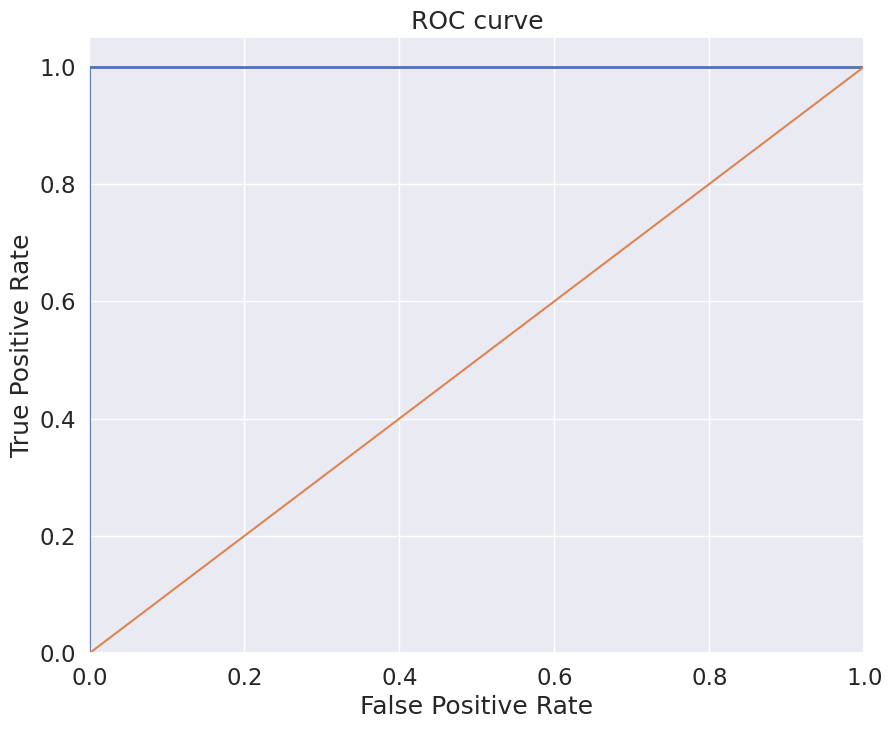

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt
import seaborn as sns
# для второй -- LogisticRegression
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y, probs)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))

sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

Custom: ROC AUC=0.999


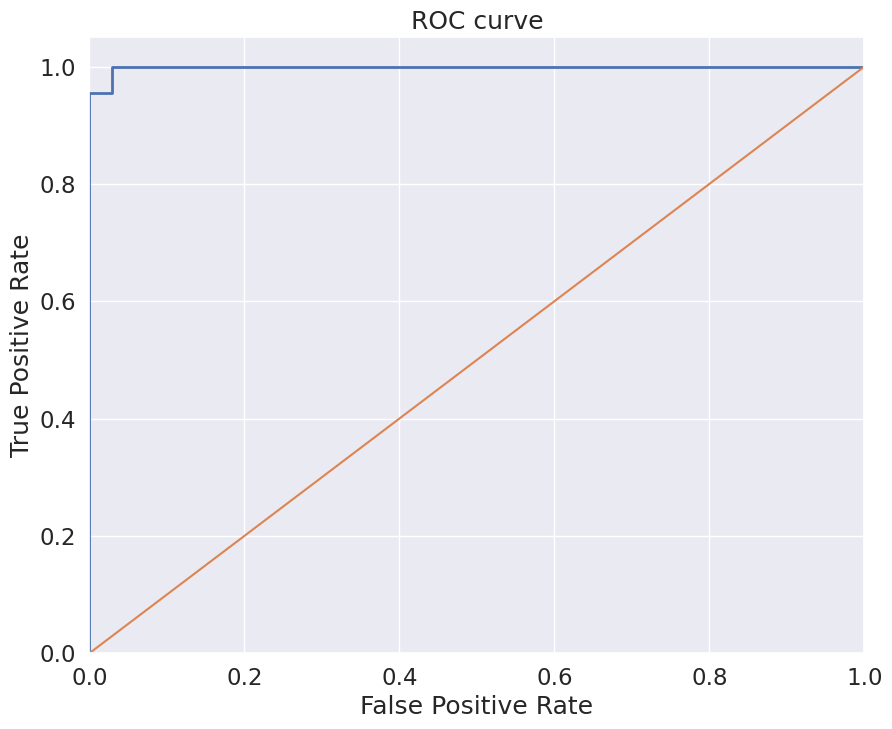

In [21]:
# для первой -- custom LogisticRegression
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y, prob)
print('Custom: ROC AUC=%.3f' % (lr_auc))

sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y, prob, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

Бонус уровень (+2 балла к этому заданию, если есть понижение): самостоятельно реализовать функцию roc_auc_score и сравнить ее с результатами выше.

In [22]:
def true_false_positive(pred, y):
    
    true_positive = np.equal(pred, 1) & np.equal(y, 1)
    true_negative = np.equal(pred, 0) & np.equal(y, 0)
    false_positive = np.equal(pred, 1) & np.equal(y, 0)
    false_negative = np.equal(pred, 0) & np.equal(y, 1)

    tpr = true_positive.sum() / (true_positive.sum() + false_negative.sum())
    fpr = false_positive.sum() / (false_positive.sum() + true_negative.sum())

    return tpr, fpr

In [23]:
def roc_(prob, y, n=100):
    
    roc = np.array([])
    for i in range(n + 1):
        threshold_vector = np.greater_equal(prob, i / n).astype(int)
        tpr, fpr = true_false_positive(threshold_vector, y)
        roc = np.append(roc, [fpr, tpr])
    
    roc = roc.reshape(-1, 2)
    tpr = roc[:,0]
    fpr = roc[:,1]
    
    #integrating from right to left flips the sign of the result
    auc = -1 * np.trapz(fpr,tpr)
    print('CUSTOM ROC_AUC_SCORE=%.3f' % (auc))
    
    return roc

ROC AUC SKLEARN=1.000
CUSTOM ROC_AUC_SCORE=1.000


Text(0, 0.5, 'True Positive Rate')

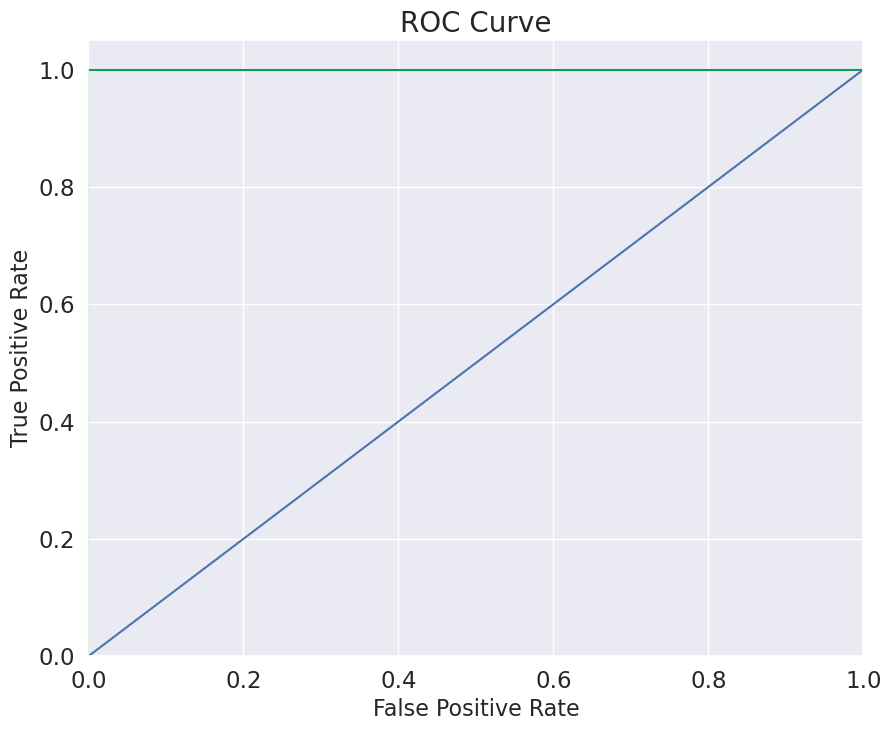

In [24]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 8))

lr_auc = roc_auc_score(y, probs)
print('ROC AUC SKLEARN=%.3f' % (lr_auc))

ROC = roc_(probs, y)
plt.plot(ROC[:,0],ROC[:,1],color='#0F9D58')
plt.title('ROC Curve',fontsize=20)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)

In [25]:
prob = np.hstack(prob)

ROC AUC SKLEARN=0.999
CUSTOM ROC_AUC_SCORE=0.999


Text(0, 0.5, 'True Positive Rate')

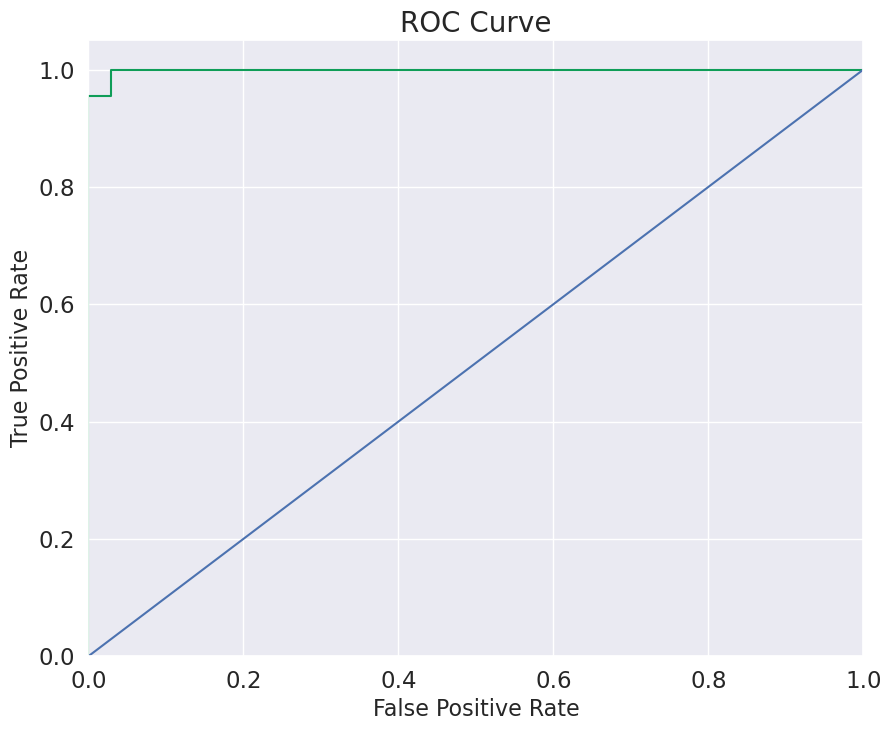

In [26]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 8))

lr_auc = roc_auc_score(y, prob)
print('ROC AUC SKLEARN=%.3f' % (lr_auc))

ROC = roc_(prob, y)
plt.plot(ROC[:,0],ROC[:,1],color='#0F9D58')
plt.title('ROC Curve',fontsize=20)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)

## На других данных

In [27]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
clf = LogisticRegression(solver="liblinear").fit(X_train, y_train)

ROC AUC SKLEARN=0.997


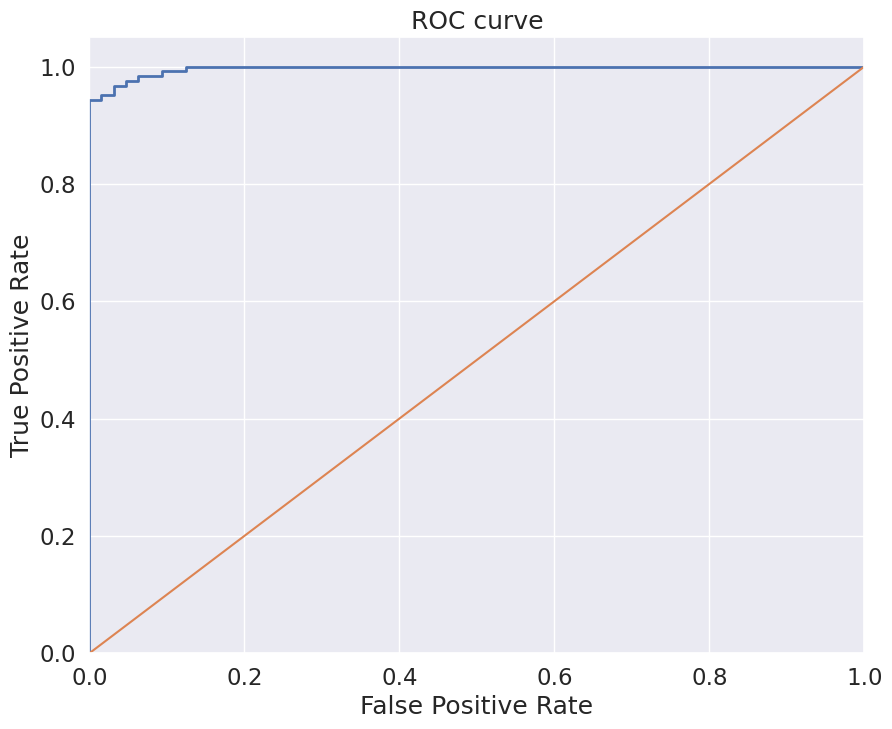

In [28]:
#ROC curve sklearn
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
lr_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print('ROC AUC SKLEARN=%.3f' % (lr_auc))

fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

CUSTOM ROC_AUC_SCORE=0.997


Text(0, 0.5, 'True Positive Rate')

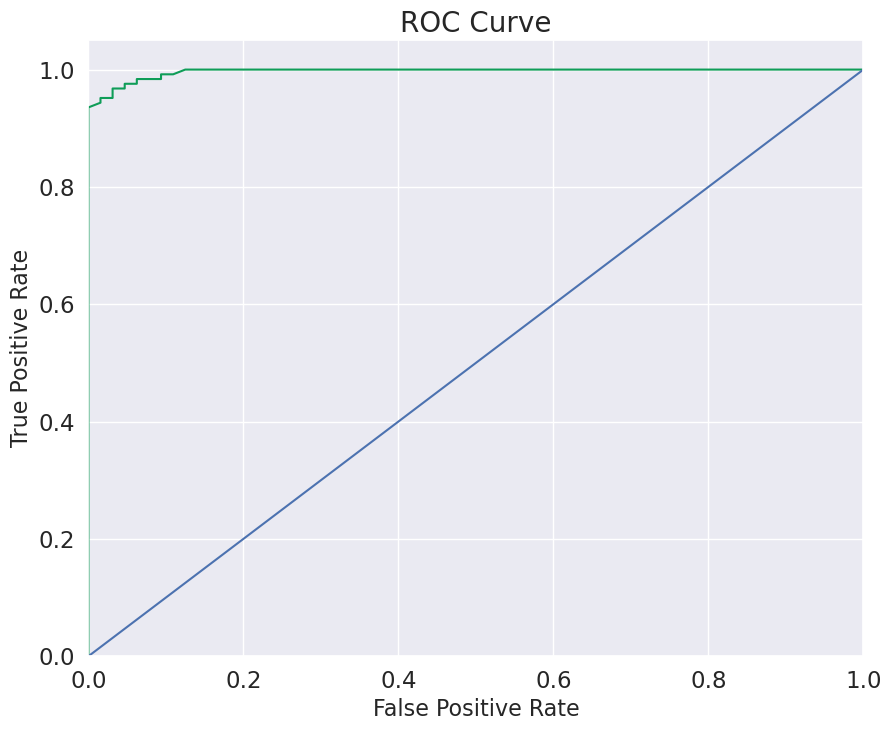

In [29]:
#Custom ROC curve
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 8))


ROC = roc_(clf.predict_proba(X_test)[:, 1], y_test)
plt.plot(ROC[:,0],ROC[:,1],color='#0F9D58')
plt.title('ROC Curve',fontsize=20)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)